In [83]:
# base: https://github.com/Followb1ind1y/Face-Mask-Detection/tree/main

import os
import json
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
from tqdm import trange

main_dir = "...root..." 
train_dir = "train" 
val_dir = "val"
test_dir = "test"
image_dir = "images"
annotation_dir = "annotations" 
model_dir = "model"

# main_dir
# ---- train_dir
# -------- images
# -------- annotations
# ---- val_dir
# -------- images
# -------- annotations
# ---- test_dir
# -------- images
# -------- annotations

batch_size = 4
num_classes = 3
num_epochs = 30
model_name = "model_epoch_"

# buildings (class 1) and forrest outliers (class 2)
# return example ([[0 1 0 1], [1 1 3 2], [1 3 5 4]] [1, 1, 2])
def get_annotations_boxes_from_json(file):
    boxes = []
    annotations = []
    with open(file, 'r') as f:
        data = json.load(f)

        for _ in data["shapes"]:
            
            x1 = _["points"][0][0]
            y1 = _["points"][0][1]
            x2 = _["points"][1][0]
            y2 = _["points"][1][1]
            
            if x1 < x2:
                xmin = x1
                xmax = x2
            else:
                xmin = x2
                xmax = x1
                
            if y1 < y2:
                ymin = y1
                ymax = y2
            else:
                ymin = y2
                ymax = y1
            
            points = [xmin, ymin, xmax, ymax]
            
            if _["label"] == "building":
                label_id = 1
            else:
                label_id = 2
            boxes.append(points)    
            annotations.append(label_id)    
    return boxes, annotations

class UrbanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, image_dir))))
        self.anns = list(sorted(os.listdir(os.path.join(root, annotation_dir))))
        self.img_dir = os.path.join(root, image_dir)
        self.ann_dir = os.path.join(root, annotation_dir)
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        curr_img_dir = os.path.join(self.img_dir, self.imgs[idx])
        curr_ann_dir = os.path.join(self.ann_dir, self.anns[idx])

        image = Image.open(curr_img_dir, mode='r').convert('RGB')
        boxes, labels = get_annotations_boxes_from_json(curr_ann_dir)
        
        boxes = torch.FloatTensor(boxes)
        labels = torch.LongTensor(labels)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, category_ids=labels)

        tenn = transforms.ToTensor()
        image = tenn(image)

        return image, boxes, labels

    def collate_fn(self, batch):
        return tuple(zip(*batch))

data_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

image_datasets = {x: UrbanDataset(root=os.path.join(main_dir, x), transforms=None) for x in [train_dir, val_dir, test_dir]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, collate_fn=image_datasets[x].collate_fn) for x in [train_dir, val_dir, test_dir]}
dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir, test_dir]}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def display_boundary(image, boxes, labels, score = None):

    label_to_name = {1: 'Building', 2: 'Outlier'}
    label_to_color = {1: 'red', 2: 'green'}

    transform = torchvision.transforms.ToPILImage()
    image = transform(image)
    boxes = boxes.tolist()
    labels = labels.tolist()

    img_bbox = ImageDraw.Draw(image)

    for idx in range(len(boxes)):
        img_bbox.rectangle(boxes[idx], outline=label_to_color[labels[idx]], width=2)
        if score == None: 
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]], 
                          align ="left", fill=label_to_color[labels[idx]]) 
        else:
            img_bbox.text((boxes[idx][0], boxes[idx][1]-15), label_to_name[labels[idx]]+' '+ f"{score[idx].item():.2%}", 
                          align ="left", fill=label_to_color[labels[idx]])
    
    return image

def display_images(**images):
    num_images = len(images)
    plt.figure(figsize=(15,15))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, num_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=15)
        plt.imshow(image)
    plt.show()


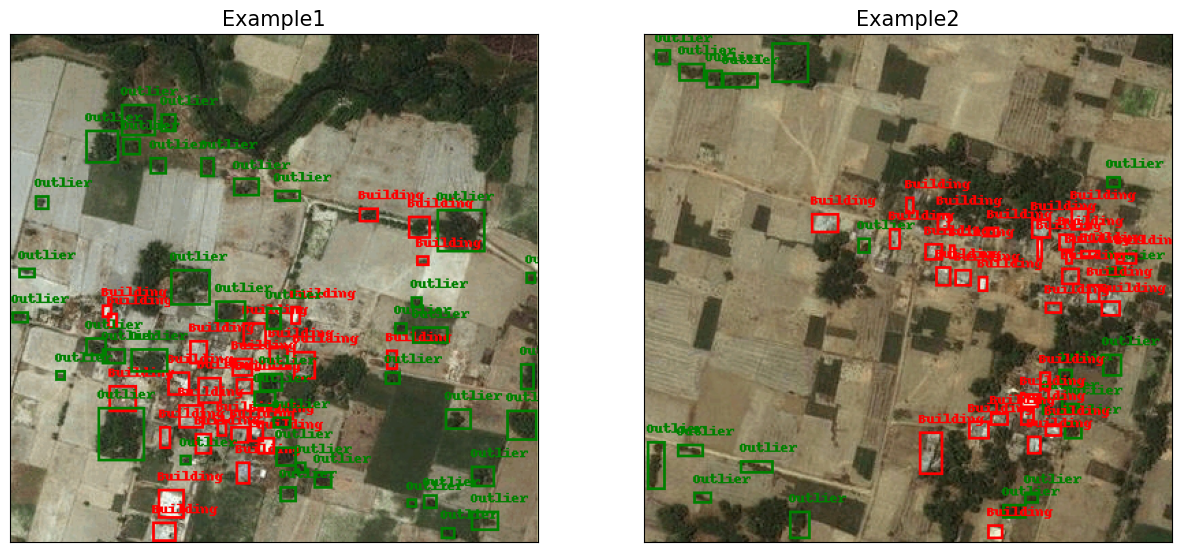

In [84]:
images, boxes, labels = next(iter(dataloaders[train_dir]))

display_images(
    Example1=display_boundary(images[0], boxes[0], labels[0]),
    Example2=display_boundary(images[1], boxes[1], labels[1])
)

In [85]:
weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=weights)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# model.eval()

In [86]:
def save_model(model: torch.nn.Module, target_dir: str, epoch: int, start: int):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)
    check_point_name = model_name + str(start+epoch)
    model_save_path = target_dir_path / check_point_name
    torch.save(obj=model.state_dict(), f=model_save_path)

def plot_curve(results: dict, epochs: int):
    train_losses = np.array(results["train_loss"])
    plt.plot(np.arange(epochs, step=1), train_losses, label='Train loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
def bbox_iou(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]

    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )

    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

In [87]:
class Trainer:
    def __init__(self, 
                 model: torch.nn.Module,
                 dataloaders: torch.utils.data.DataLoader,
                 epochs: int, 
                 metric: torch.nn.Module, 
                 criterion: torch.nn.Module, 
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler,
                 save_dir: str,
                 device: torch.device,
                 start: int):
        
        self.model = model
        self.train_dataloader = dataloaders[train_dir]
        self.val_dataloader = dataloaders[val_dir]
        self.epoch = 0
        self.epochs = epochs
        self.metric = None
        self.criterion = None
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_dir = save_dir
        self.device = device
        self.start = start

        self.results = {"train_loss": [],
                        "train_iou": [],
                        "val_loss": [],
                        "val_iou": []
                        }
        
    def train_model(self):
        start_time = time.time()

        progressbar = trange(self.epochs, desc="Progress")
        for _ in progressbar:
            self.epoch += 1
            self.train_epoch()
            print(f'\nEpoch {self.epoch}: Train loss: {self.results["train_loss"][-1]}')
            save_model(self.model, self.save_dir, self.epoch, self.start)

        time_elapsed = time.time() - start_time
        print('\n')
        print('-' * 20)
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        plot_curve(results=self.results, epochs=self.epochs)

        return self.results

    def train_epoch(self):
        self.model.train()
        running_losses = []

        for images, boxes, labels in self.train_dataloader:
            images = list(img.to(self.device) for img in images)
            boxes = [b.to(self.device) for b in boxes]
            labels = [l.to(self.device) for l in labels]
            targets = []

            for i in range(len(images)):
                d = {}
                d['boxes'] = boxes[i]
                d['labels'] = labels[i]
                targets.append(d)

            self.optimizer.zero_grad()

            loss_dict = self.model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss_value = loss.item()
            running_losses.append(loss_value)

            loss.backward()
            self.optimizer.step()

        self.scheduler.step()
        self.results["train_loss"].append(np.mean(running_losses))

    def val_epoch(self):
        self.model.eval()
        running_ious, running_losses = [], []

        for x, y in self.val_dataloader:
            inputs = x.to(self.device)
            targets = y.to(self.device)

            with torch.no_grad():
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss_value = loss.item()
                running_losses.append(loss_value)

                iou_value = self.metric(outputs, targets)
                running_ious.append(iou_value)

        self.results["val_loss"].append(np.mean(running_losses))
        self.results["val_iou"].append(np.mean(running_ious))
        
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer_RCNN = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler_RCNN = lr_scheduler.StepLR(optimizer_RCNN, step_size=7, gamma=0.1)

Progress:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Train loss: 1.5663640449444454


Progress:   3%|▎         | 1/30 [00:02<01:10,  2.42s/it]


Epoch 2: Train loss: 1.382258415222168


Progress:   7%|▋         | 2/30 [00:04<01:07,  2.42s/it]


Epoch 3: Train loss: 1.3084726631641388


Progress:  10%|█         | 3/30 [00:07<01:03,  2.34s/it]


Epoch 4: Train loss: 1.2739815215269725


Progress:  13%|█▎        | 4/30 [00:09<00:59,  2.31s/it]


Epoch 5: Train loss: 1.212125579516093


Progress:  17%|█▋        | 5/30 [00:11<00:58,  2.33s/it]


Epoch 6: Train loss: 1.222186654806137


Progress:  20%|██        | 6/30 [00:13<00:54,  2.26s/it]


Epoch 7: Train loss: 1.1513213366270065


Progress:  23%|██▎       | 7/30 [00:16<00:53,  2.31s/it]


Epoch 8: Train loss: 1.123340328534444


Progress:  27%|██▋       | 8/30 [00:18<00:51,  2.34s/it]


Epoch 9: Train loss: 1.0787408649921417


Progress:  30%|███       | 9/30 [00:21<00:50,  2.39s/it]


Epoch 10: Train loss: 1.0570687005917232


Progress:  33%|███▎      | 10/30 [00:23<00:48,  2.40s/it]


Epoch 11: Train loss: 1.0943003743886948


Progress:  37%|███▋      | 11/30 [00:25<00:45,  2.38s/it]


Epoch 12: Train loss: 1.0533577154080074


Progress:  40%|████      | 12/30 [00:28<00:45,  2.55s/it]


Epoch 13: Train loss: 1.080401008327802


Progress:  43%|████▎     | 13/30 [00:31<00:42,  2.49s/it]


Epoch 14: Train loss: 1.0758760621150334


Progress:  47%|████▋     | 14/30 [00:33<00:38,  2.41s/it]


Epoch 15: Train loss: 1.03410238524278


Progress:  50%|█████     | 15/30 [00:35<00:35,  2.34s/it]


Epoch 16: Train loss: 1.0843707571427028


Progress:  53%|█████▎    | 16/30 [00:37<00:32,  2.33s/it]


Epoch 17: Train loss: 1.0571691940228145


Progress:  57%|█████▋    | 17/30 [00:40<00:30,  2.33s/it]


Epoch 18: Train loss: 1.0753570000330608


Progress:  60%|██████    | 18/30 [00:42<00:27,  2.33s/it]


Epoch 19: Train loss: 1.0184151381254196


Progress:  63%|██████▎   | 19/30 [00:44<00:25,  2.32s/it]


Epoch 20: Train loss: 1.0753366996844609


Progress:  67%|██████▋   | 20/30 [00:47<00:22,  2.30s/it]


Epoch 21: Train loss: 1.0563517808914185


Progress:  70%|███████   | 21/30 [00:49<00:20,  2.32s/it]


Epoch 22: Train loss: 1.0334021151065826


Progress:  73%|███████▎  | 22/30 [00:51<00:18,  2.34s/it]


Epoch 23: Train loss: 1.0724609742561977


Progress:  77%|███████▋  | 23/30 [00:54<00:16,  2.37s/it]


Epoch 24: Train loss: 1.0413858890533447


Progress:  80%|████████  | 24/30 [00:57<00:14,  2.48s/it]


Epoch 25: Train loss: 1.062684178352356


Progress:  83%|████████▎ | 25/30 [00:59<00:12,  2.59s/it]


Epoch 26: Train loss: 1.0752453207969666


Progress:  87%|████████▋ | 26/30 [01:02<00:10,  2.63s/it]


Epoch 27: Train loss: 1.0758215288321178


Progress:  90%|█████████ | 27/30 [01:05<00:07,  2.62s/it]


Epoch 28: Train loss: 1.0600392321745555


Progress:  93%|█████████▎| 28/30 [01:07<00:05,  2.51s/it]


Epoch 29: Train loss: 1.0279393444458644


Progress:  97%|█████████▋| 29/30 [01:09<00:02,  2.43s/it]


Epoch 30: Train loss: 1.0524340718984604


Progress: 100%|██████████| 30/30 [01:12<00:00,  2.41s/it]



--------------------
Training complete in 1m 12s


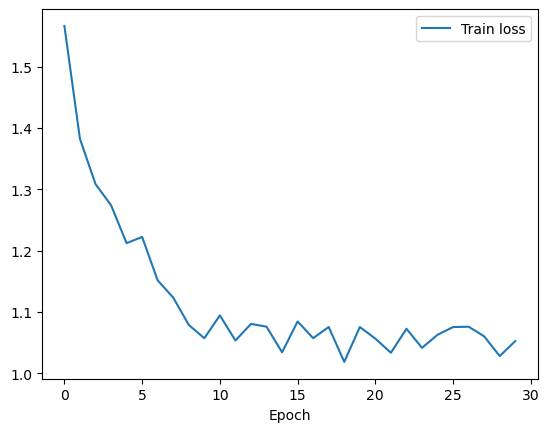

In [88]:
trainer = Trainer(model=model,
                  dataloaders=dataloaders,
                  epochs=num_epochs,
                  metric=None,
                  criterion=None, 
                  optimizer=optimizer_RCNN,
                  scheduler=exp_lr_scheduler_RCNN,
                  save_dir=main_dir + "/" + model_dir,
                  device=device,
                  start=0)

model_results = trainer.train_model()

In [98]:
count_epoch = []

for filename in os.listdir(main_dir + "/" + model_dir):
    if (filename.startswith("model")):
        count_epoch.append(int(filename.split("_")[2]))

dir_load = main_dir + "/" + model_dir + "/" + model_name + str(max(count_epoch))    

model_state = torch.load(dir_load, weights_only=True)
model.load_state_dict(model_state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer_UNet = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler_UNet = lr_scheduler.StepLR(optimizer_UNet, step_size=7, gamma=0.1)

def remove_low_risk_box(predictions, threshold):

    for img in range(len(predictions)):
        for idx in range(predictions[img]['labels'].shape[0]):
            if predictions[img]['scores'][idx] < threshold:
                predictions[img]['boxes'] = predictions[img]['boxes'][0:idx]
                predictions[img]['labels'] = predictions[img]['labels'][0:idx]
                predictions[img]['scores'] = predictions[img]['scores'][0:idx]
                break

    return predictions
    
def nms_pytorch(P : torch.tensor, labels: torch.tensor, scores: torch.tensor, thresh_iou : float):
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
 
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()
    pred_dict = {'boxes':[], 'labels':[], 'scores':[]}
     
    while len(order) > 0:
        idx = order[-1]
        if len(pred_dict['boxes']) == 0:
            pred_dict['boxes'].append(torch.unsqueeze(P[idx], dim=0))
            pred_dict['labels'].append(torch.unsqueeze(labels[idx], dim=0))
            pred_dict['scores'].append(torch.unsqueeze(scores[idx], dim=0))
        else:
            pred_dict['boxes'][0] = torch.cat((pred_dict['boxes'][0], torch.unsqueeze(P[idx], dim=0)), dim=0)
            pred_dict['labels'][0] = torch.cat((pred_dict['labels'][0], torch.unsqueeze(labels[idx], dim=0)), dim=0)
            pred_dict['scores'][0] = torch.cat((pred_dict['scores'][0], torch.unsqueeze(scores[idx], dim=0)), dim=0)
 
        order = order[:-1]
 
        if len(order) == 0:
            break
         
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
 
        w = xx2 - xx1
        h = yy2 - yy1
         
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
 
        inter = w*h
 
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
 
        union = (rem_areas - inter) + areas[idx]
         
        IoU = inter / union
 
        mask = IoU < thresh_iou
        order = order[mask]
    
    pred_dict['boxes'], pred_dict['labels'], pred_dict['scores'] = pred_dict['boxes'][0], pred_dict['labels'][0], pred_dict['scores'][0]
    return pred_dict

def apply_nms(predictions, threshold):
    nms_list = []
    for img in range(len(predictions)):
        nms_list.append(nms_pytorch(predictions[img]['boxes'], predictions[img]['labels'], predictions[img]['scores'], threshold))
    return nms_list

images, boxes, labels = next(iter(dataloaders[test_dir]))
images = list(img.to(device) for img in images)

model.eval()
predictions = model(images)
predictions = remove_low_risk_box(predictions=predictions, threshold=0.5)
predictions = apply_nms(predictions, 0.5)

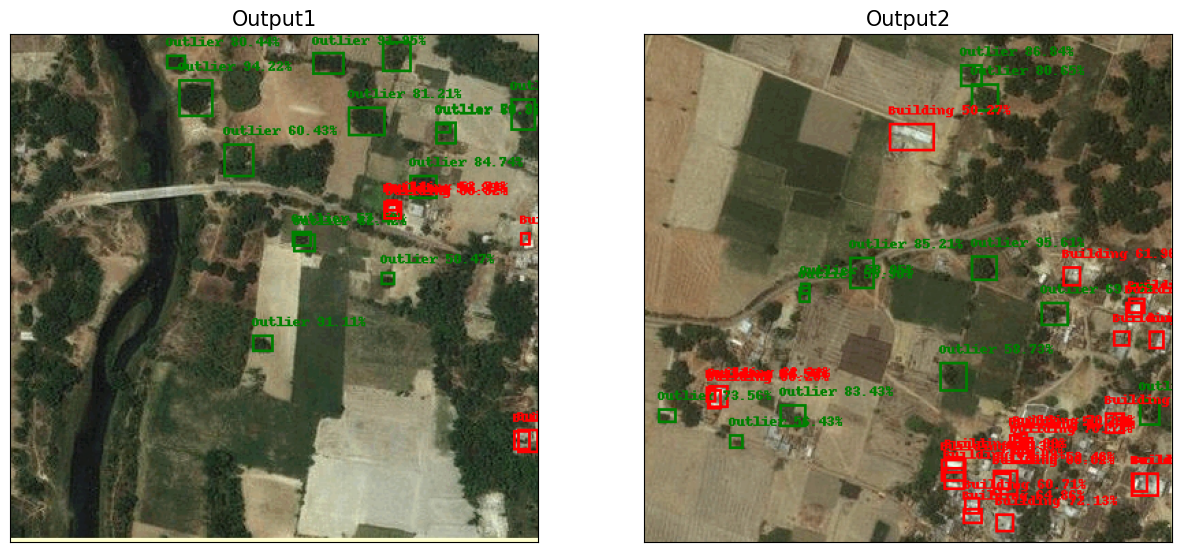

In [99]:
display_images(
    Output1=display_boundary(images[0], predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']),
    Output2=display_boundary(images[1], predictions[1]['boxes'], predictions[1]['labels'], predictions[1]['scores'])
)

In [ ]:
# ---------------------------------- fine tuning ------------------------------------- #

In [100]:
trained_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn()
trained_in_features = trained_model.roi_heads.box_predictor.cls_score.in_features
trained_model.roi_heads.box_predictor = FastRCNNPredictor(trained_in_features, num_classes)
# trained_model.eval()

start_epoch = 30
end_epoch = 40
batch_epoch = end_epoch - start_epoch

Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1: Train loss: 1.054608146349589


Progress:  10%|█         | 1/10 [00:02<00:22,  2.46s/it]


Epoch 2: Train loss: 1.0955205708742142


Progress:  20%|██        | 2/10 [00:04<00:18,  2.35s/it]


Epoch 3: Train loss: 1.061268036564191


Progress:  30%|███       | 3/10 [00:06<00:15,  2.28s/it]


Epoch 4: Train loss: 1.0529336233933766


Progress:  40%|████      | 4/10 [00:09<00:13,  2.24s/it]


Epoch 5: Train loss: 1.0806723535060883


Progress:  50%|█████     | 5/10 [00:11<00:11,  2.23s/it]


Epoch 6: Train loss: 1.063727507988612


Progress:  60%|██████    | 6/10 [00:13<00:08,  2.20s/it]


Epoch 7: Train loss: 1.061690906683604


Progress:  70%|███████   | 7/10 [00:15<00:06,  2.17s/it]


Epoch 8: Train loss: 1.0507998665173848


Progress:  80%|████████  | 8/10 [00:17<00:04,  2.18s/it]


Epoch 9: Train loss: 1.0449073165655136


Progress:  90%|█████████ | 9/10 [00:19<00:02,  2.19s/it]


Epoch 10: Train loss: 1.0648461729288101


Progress: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]



--------------------
Training complete in 0m 22s


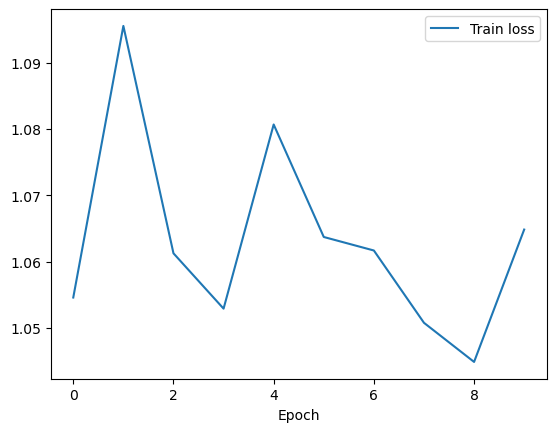

In [101]:
start_model = main_dir + "/" + model_dir + "/" + model_name + str(start_epoch)

trained_checkpoint = torch.load(start_model, weights_only=True)
trained_model.load_state_dict(trained_checkpoint)

if torch.cuda.is_available():
    trained_model.cuda()

trained_trainer = Trainer(model=trained_model,
                  dataloaders=dataloaders,
                  epochs=batch_epoch,
                  metric=None,
                  criterion=None, 
                  optimizer=optimizer_RCNN,
                  scheduler=exp_lr_scheduler_RCNN,
                  save_dir=main_dir + "/" + model_dir + "/new",
                  device=device,
                  start=start_epoch)

trained_model_results = trained_trainer.train_model()

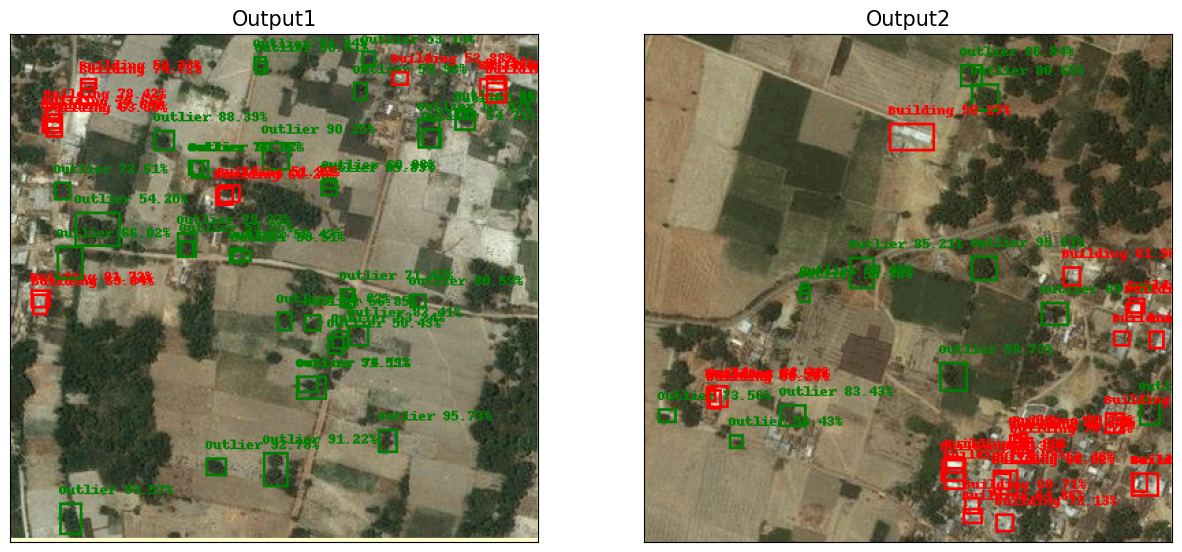

In [102]:
trained_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn()
trained_in_features = trained_model.roi_heads.box_predictor.cls_score.in_features
trained_model.roi_heads.box_predictor = FastRCNNPredictor(trained_in_features, num_classes)

tuned_dir_load = main_dir + "/" + model_dir + "/" + "new/" + model_name + str(end_epoch)    
tuned_model_state = torch.load(tuned_dir_load, weights_only=True)
trained_model.load_state_dict(tuned_model_state)

trained_model = trained_model.to(device)

trained_params = [p for p in trained_model.parameters() if p.requires_grad]
trained_optimizer_UNet = torch.optim.SGD(trained_params, lr=0.005, momentum=0.9, weight_decay=0.0005)
trained_exp_lr_scheduler_UNet = lr_scheduler.StepLR(trained_optimizer_UNet, step_size=7, gamma=0.1)

images, boxes, labels = next(iter(dataloaders[test_dir]))
images = list(img.to(device) for img in images)

trained_model.eval()
trained_predictions = trained_model(images)
trained_predictions = remove_low_risk_box(predictions=trained_predictions, threshold=0.5)
trained_predictions = apply_nms(trained_predictions, 0.5)

display_images(
    Output1=display_boundary(images[0], trained_predictions[0]['boxes'], trained_predictions[0]['labels'], trained_predictions[0]['scores']),
    Output2=display_boundary(images[1], trained_predictions[1]['boxes'], trained_predictions[1]['labels'], trained_predictions[1]['scores'])
)